# import

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             accuracy_score, 
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, 
                              TensorDataset, 
                              random_split, 
                              WeightedRandomSampler)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [13]:
# filepath
train_geno_dose_path = 'data/train/sim_n300_p1000.mldose'
train_geno_info_path = 'data/train/sim_n300_p1000.mlinfo'
train_pheno_conti_path = 'data/train/pheno_n300_conti.phe'
train_pheno_binary_path = 'data/train/pheno_n300_binary.phe'

test_geno_dose_path = 'data/test/sim_n150_p1000.mldose'
test_geno_info_path = 'data/test/sim_n150_p1000.mlinfo'
test_pheno_conti_path = 'data/test/pheno_n150_conti.phe'
test_pheno_binary_path = 'data/test/pheno_n150_binary.phe'

# load_data(geno : x, pheno : y)
train_geno_info = pd.read_csv(train_geno_info_path, delim_whitespace=True)
train_geno_dose = pd.read_csv(train_geno_dose_path, delim_whitespace=True, header=None)
train_pheno_conti = pd.read_csv(train_pheno_conti_path, delim_whitespace=True, header=None, names=['family_id', 'individual_id', 'pheno_1_cont', 'pheno_2_cont'])
train_pheno_binary = pd.read_csv(train_pheno_binary_path, delim_whitespace=True, header=None, names=['family_id', 'individual_id', 'pheno_1_bin', 'pheno_2_bin'])

test_geno_info = pd.read_csv(test_geno_info_path, delim_whitespace=True)
test_geno_dose = pd.read_csv(test_geno_dose_path, delim_whitespace=True, header=None)
test_pheno_conti = pd.read_csv(test_pheno_conti_path, delim_whitespace=True, header=None, names=['family_id', 'individual_id', 'pheno_1_cont', 'pheno_2_cont'])
test_pheno_binary = pd.read_csv(test_pheno_binary_path, delim_whitespace=True, header=None, names=['family_id', 'individual_id', 'pheno_1_bin', 'pheno_2_bin'])

# add column names to 'train_geno_dose', 'test_geno_dose'
num_snp = train_geno_dose.shape[1] - 2
snp_columns = ['family_id', 'individual_id'] + [f'snp_{i+1}' for i in range(num_snp)]
train_geno_dose.columns = snp_columns
test_geno_dose.columns = snp_columns

In [19]:
train_pheno_binary['pheno_1_bin'].value_counts()

0    240
1     60
Name: pheno_1_bin, dtype: int64

# Linear Regression Model

In [15]:
# continuous phenotype 1
X_train_conti_1 = train_geno_dose.drop(columns=['family_id', 'individual_id'])
y_train_conti_1 = train_pheno_conti['pheno_1_cont']

X_test_conti_1 = test_geno_dose.drop(columns=['family_id', 'individual_id'])
y_test_conti_1 = test_pheno_conti['pheno_1_cont']

# create model and train
lr_conti_1 = LinearRegression()
lr_conti_1.fit(X_train_conti_1, y_train_conti_1)

# evaluation
y_pred_conti_1 = lr_conti_1.predict(X_test_conti_1)
mse_conti_1 = mean_squared_error(y_test_conti_1, y_pred_conti_1)
r2_conti_1 = r2_score(y_test_conti_1, y_pred_conti_1)
print(f'Phenotype 1 - Mean Squared Error: {mse_conti_1}, R^2: {r2_conti_1}')

# continuous phenotype 2
X_train_conti_2 = train_geno_dose.drop(columns=['family_id', 'individual_id'])
y_train_conti_2 = train_pheno_conti['pheno_2_cont']

X_test_conti_2 = test_geno_dose.drop(columns=['family_id', 'individual_id'])
y_test_conti_2 = test_pheno_conti['pheno_2_cont']

# create model and train
lr_conti_2 = LinearRegression()
lr_conti_2.fit(X_train_conti_2, y_train_conti_2)

# evaluation
y_pred_conti_2 = lr_conti_2.predict(X_test_conti_2)
mse_conti_2 = mean_squared_error(y_test_conti_2, y_pred_conti_2)
r2_conti_2 = r2_score(y_test_conti_2, y_pred_conti_2)
print(f'Phenotype 2 - Mean Squared Error: {mse_conti_2}, R^2: {r2_conti_2}')


Phenotype 1 - Mean Squared Error: 1.2350703853846532, R^2: -0.5230094882332861
Phenotype 2 - Mean Squared Error: 1.846637701109589, R^2: -0.6325642282163606


### To evaluate the performance of Linear Regression Model, the distribution of the phenotype value should be observed

        phenotype
count  150.000000
mean    -0.001950
std      0.903539
min     -2.176106
25%     -0.650287
50%     -0.039415
75%      0.622270
max      2.447378


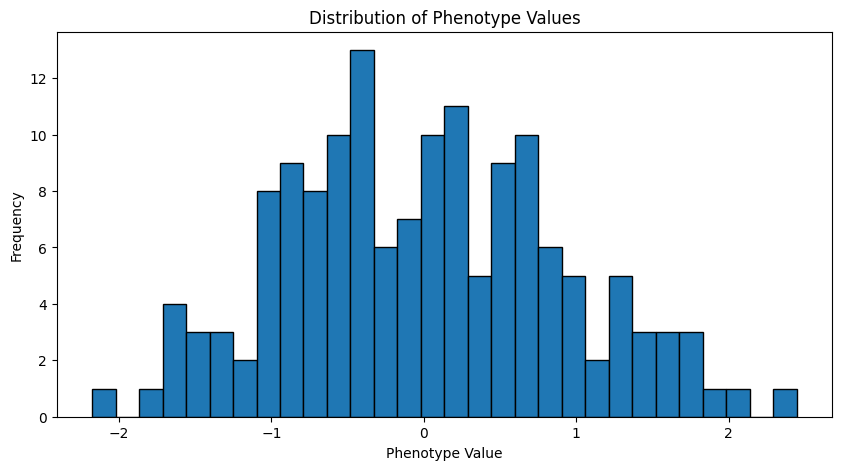

MSE: 1.23
Mean: -0.0019499005466666727
Standard Deviation: 0.9035392953932577
MSE compared to variance: 1.5066


In [16]:
# load phenotype 1 value
data = [
    0.028128298, 0.358461591, 0.603441541, 1.653470258, 1.027787063, 0.093096175, -0.440158937,
    0.756369374, -0.696269395, -0.358332733, 0.474527679, -1.474454168, -1.673426848, -1.731714681,
    -1.615990307, 0.284435222, 1.261189002, -0.938802742, 0.642208053, -0.329627501, -0.21727992,
    -1.266025247, 0.627311328, -0.140724347, 1.721589094, 0.199096746, -0.495246916, -0.652361409,
    0.251520451, -0.553690433, -0.341106515, -0.333178001, -1.054517922, 1.736482494, 1.894129486,
    2.447377803, 0.607147479, -0.874025346, -0.927020424, 1.038446868, 0.648652253, -0.211584289,
    -0.744507315, -0.546784845, -1.031229234, 1.546773437, -0.345335613, -0.32880528, 1.280655391,
    -0.187912638, 0.969056383, -1.07869925, -0.181429134, 0.471601618, 0.509340734, -0.155747706,
    -1.466032703, 0.208537005, -1.586660025, 0.191919907, -1.62203575, 1.395187324, -0.013851561,
    0.868835954, 0.467081852, 0.026909247, -0.644063686, 1.091401627, 0.673852339, -0.344128365,
    -1.263615898, 0.331470295, 0.790974583, -0.770065259, -1.193432506, 1.288543712, -0.128702844,
    -0.479619948, -1.308843623, 1.615679999, 0.343400177, 0.909152231, -0.122539946, 0.012389022,
    0.175434594, -0.794202915, -2.176106294, 0.357501093, -0.683678419, -0.595884714, 1.284348214,
    -0.924653211, 0.558023961, 0.206571785, 0.263442272, 0.83759649, 0.127594538, 1.354684297,
    -0.064978039, 0.514321446, 0.630233787, 0.155652608, 0.558229392, 0.070235865, 0.066786543,
    -0.542848431, -0.896021665, -1.435930331, -0.3387587, -0.898381037, 1.40151916, -0.191970844,
    -0.116573533, 0.221219338, -0.485404023, -0.855695318, 0.75152509, 0.702750898, 0.824651568,
    -0.505417041, -0.068299997, 0.287975995, 1.022474931, 0.454725859, -0.744766845, 0.424719691,
    -1.177788103, -1.064919674, -0.566848797, -1.093590056, -0.868334127, 0.904841074, 0.005020476,
    1.457680516, -0.731909187, 0.017516974, -0.602486652, -0.379343504, 0.478345479, -0.542177515,
    -0.456306402, 0.652764557, -1.037944876, 1.204962512, -1.055644527, 2.009900774, 1.695812443,
    -0.977097996, -0.33180289, -0.243833524
]

df = pd.DataFrame(data, columns=['phenotype'])

print(df.describe())

plt.figure(figsize=(10, 5))
plt.hist(df['phenotype'], bins=30, edgecolor='k')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.title('Distribution of Phenotype Values')
plt.show()

# observing other statistic values to evaluate MSE value
mse_value = 1.23
print(f'MSE: {mse_value}')

mean_value = df['phenotype'].mean()
std_value = df['phenotype'].std()
print(f'Mean: {mean_value}')
print(f'Standard Deviation: {std_value}')
print(f'MSE compared to variance: {mse_value / std_value**2:.4f}')


        phenotype
count  150.000000
mean    -0.017924
std      1.067108
min     -2.771143
25%     -0.660495
50%     -0.025782
75%      0.646972
max      2.777488


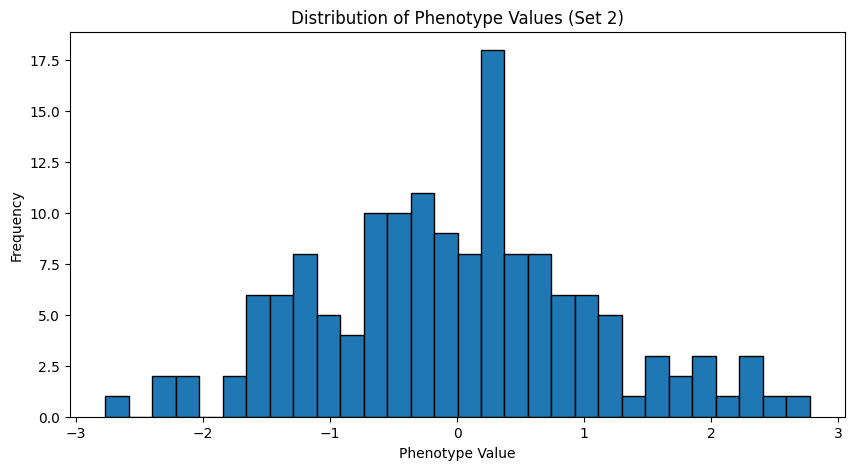

MSE: 1.84
Mean: -0.01792405815333337
Standard Deviation: 1.0671075831635484
MSE compared to variance: 1.6159


In [17]:
# load phenotype 2 value
data2 = [
    0.719464786, -1.020879989, 0.840851549, -1.606826738, 1.210292594, -2.050496745, 1.679829285,
    0.151960942, 0.390622775, -0.589288192, 0.449485171, -1.31077116, -0.766356879, -2.319203579,
    -1.733289735, -0.386176798, -1.660114062, 0.324618207, 0.119390563, 1.560609386, -1.175368491,
    -0.249567593, -0.635781418, 1.010129039, 0.077591506, 0.642535195, -0.208720168, -0.589023141,
    0.415798726, -0.92745388, -1.669925779, 0.307228521, 0.648451559, -0.53682637, 0.272063493,
    1.591273802, -0.942386385, -0.137876428, -0.660320909, 0.772605642, -0.752487713, -0.157767121,
    0.498886051, 0.797955364, -2.078610402, 0.462238955, 2.156024383, 1.997894084, -0.640420399,
    -0.414258875, -0.479104307, -1.140942339, 0.907619148, 0.187867001, 1.776272803, -1.171134264,
    -0.648699605, 0.035197774, -1.149104026, 2.77748802, 0.704001968, -0.677611586, -0.601878973,
    1.192009921, -1.285137521, 0.284957176, -0.04494953, -1.418182634, 0.327350898, -0.515027361,
    1.209337142, 1.937886744, -0.916523028, 0.364441274, 0.942540317, -0.660553259, 2.390521171,
    -1.352654851, -0.929598627, -0.38238695, 0.654787655, 1.550880313, 0.360591755, -0.381127601,
    0.985205791, 0.377902254, 1.178449186, -1.459091539, -1.515600106, -0.107151941, -0.032615859,
    -0.502341226, 0.925038001, 0.22948855, 1.267950809, 0.337271665, 1.106505255, 2.286116432,
    1.879650096, -1.231487703, 1.09357702, 0.317097267, -1.48947207, -0.439825884, -1.509131376,
    -1.130806333, 0.679911975, 0.421580188, -0.743411338, -1.190450863, -0.627131545, -0.031854217,
    0.010831955, -0.091727452, -0.189629439, 0.232724361, -0.408925915, -0.019709815, -0.239389072,
    0.819827526, -0.283641125, 1.333997346, -0.299083284, 0.24730268, 0.287336684, 0.032800781,
    0.431855626, 0.342355279, -2.771143488, 0.247542825, -1.534001906, 0.964025614, -0.313393743,
    2.508892589, -1.350921366, 2.224304199, -1.381952205, 0.21248434, -0.191856175, 0.01999145,
    -0.231018444, 0.585585609, -0.278402338, 0.685012629, -0.128301203, 0.347297597, -0.94780351,
    -0.281298545, 0.304020411, -2.386708935
]

df2 = pd.DataFrame(data2, columns=['phenotype'])

print(df2.describe())

plt.figure(figsize=(10, 5))
plt.hist(df2['phenotype'], bins=30, edgecolor='k')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.title('Distribution of Phenotype Values (Set 2)')
plt.show()


# observing other statistic values to evaluate MSE value
mse_value2 = 1.84
print(f'MSE: {mse_value2}')

mean_value2 = df2['phenotype'].mean()
std_value2 = df2['phenotype'].std()
print(f'Mean: {mean_value2}')
print(f'Standard Deviation: {std_value2}')
print(f'MSE compared to variance: {mse_value2 / std_value2**2:.4f}')


##### Conclusion : Linear Regression Model has poor performance

# Logistic Regression Model

In [5]:


# binary phenotype 1
X_train_binary_1 = train_geno_dose.drop(columns=['family_id', 'individual_id'])
y_train_binary_1 = train_pheno_binary['pheno_1_bin']

X_test_binary_1 = test_geno_dose.drop(columns=['family_id', 'individual_id'])
y_test_binary_1 = test_pheno_binary['pheno_1_bin']

# Model train
logistic_reg_model_binary_1 = LogisticRegression(max_iter=1000)
logistic_reg_model_binary_1.fit(X_train_binary_1, y_train_binary_1)

# eval
y_pred_binary_1 = logistic_reg_model_binary_1.predict(X_test_binary_1)
accuracy_binary_1 = accuracy_score(y_test_binary_1, y_pred_binary_1)
roc_auc_binary_1 = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Phenotype 1 - Accuracy: {accuracy_binary_1}, ROC AUC: {roc_auc_binary_1}')

# binary phenotype 2
X_train_binary_2 = train_geno_dose.drop(columns=['family_id', 'individual_id'])
y_train_binary_2 = train_pheno_binary['pheno_2_bin']

X_test_binary_2 = test_geno_dose.drop(columns=['family_id', 'individual_id'])
y_test_binary_2 = test_pheno_binary['pheno_2_bin']

# Model train
logistic_reg_model_binary_2 = LogisticRegression(max_iter=1000)
logistic_reg_model_binary_2.fit(X_train_binary_2, y_train_binary_2)

# eval
y_pred_binary_2 = logistic_reg_model_binary_2.predict(X_test_binary_2)
accuracy_binary_2 = accuracy_score(y_test_binary_2, y_pred_binary_2)
roc_auc_binary_2 = roc_auc_score(y_test_binary_2, y_pred_binary_2)
print(f'Phenotype 2 - Accuracy: {accuracy_binary_2}, ROC AUC: {roc_auc_binary_2}')


Phenotype 1 - Accuracy: 0.8133333333333334, ROC AUC: 0.5958962667426617
Phenotype 2 - Accuracy: 0.7866666666666666, ROC AUC: 0.5062034739454094


##### Conclusion
- Acc might seem to indicate good performance
- However AUC score implies that the model's classification performance is not satisfactory

# CNN Model
- Classification Model
- To compensate for data imbalance, different weights were implied to distinct phenotypes

### ResNet Model

In [ ]:
# ResNet model
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# ResNet50 model
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        x = self.fc(x)
        return self.sigmoid(x)

def resnet50_1d():
    return ResNet1D(ResidualBlock1D, [3, 4, 6, 3])

### Utility

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = -np.Inf
        self.delta = delta

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increase.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_acc_max = val_accuracy

### phenotype 1

Epoch 1/50, Train Loss: 0.6800, Val Loss: 0.6497, Train Acc: 0.6708, Val Acc: 0.7500, Val ROC AUC: 0.5081
Validation accuracy increased (-inf --> 0.750000).  Saving model ...
Epoch 2/50, Train Loss: 0.4269, Val Loss: 1.0348, Train Acc: 0.8208, Val Acc: 0.7500, Val ROC AUC: 0.4000
Validation accuracy increased (0.750000 --> 0.750000).  Saving model ...
Epoch 3/50, Train Loss: 0.1788, Val Loss: 2.4593, Train Acc: 0.9417, Val Acc: 0.7500, Val ROC AUC: 0.6815
Validation accuracy increased (0.750000 --> 0.750000).  Saving model ...
Epoch 4/50, Train Loss: 0.0475, Val Loss: 1.8896, Train Acc: 0.9917, Val Acc: 0.7500, Val ROC AUC: 0.6030
Validation accuracy increased (0.750000 --> 0.750000).  Saving model ...
Epoch 5/50, Train Loss: 0.0169, Val Loss: 2.0507, Train Acc: 1.0000, Val Acc: 0.7500, Val ROC AUC: 0.6015
Validation accuracy increased (0.750000 --> 0.750000).  Saving model ...
Epoch 6/50, Train Loss: 0.0267, Val Loss: 2.3648, Train Acc: 0.9958, Val Acc: 0.7500, Val ROC AUC: 0.5674
Val

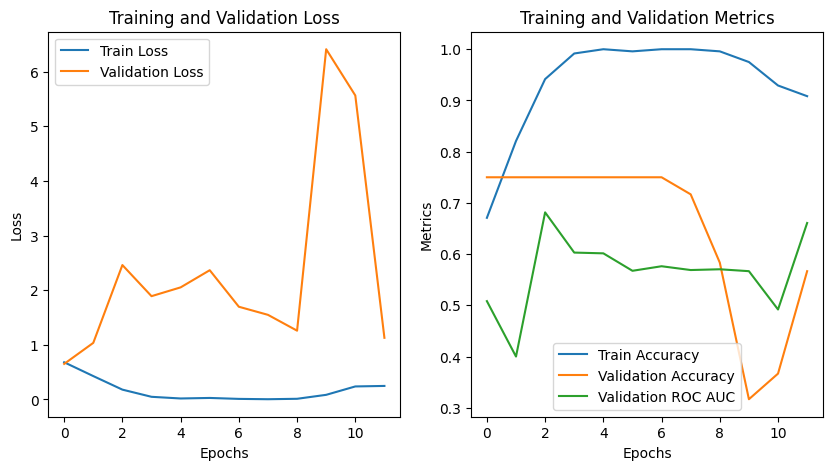

Accuracy: 0.7666666666666667
ROC AUC: 0.5297805642633229


In [153]:
# data load
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=98)

X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

# class weight
class_counts = np.bincount(y_train_binary_1.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_binary_1.astype(int)]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader_binary = DataLoader(train_data_binary, batch_size=32, sampler=sampler)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)


# ResNet50_1D
resnet_model = resnet50_1d()

# training process
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

num_epochs = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    resnet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = resnet_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    early_stopping(val_accuracy, resnet_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the best model
resnet_model.load_state_dict(torch.load('checkpoint.pt'))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
resnet_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = resnet_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.6986, Val Loss: 0.5990, Train Acc: 0.6667, Val Acc: 0.8000, Val ROC AUC: 0.6094
Validation accuracy increased (-inf --> 0.800000).  Saving model ...
Epoch 2/50, Train Loss: 0.3397, Val Loss: 1.2272, Train Acc: 0.8625, Val Acc: 0.8000, Val ROC AUC: 0.6771
Validation accuracy increased (0.800000 --> 0.800000).  Saving model ...
Epoch 3/50, Train Loss: 0.2637, Val Loss: 0.9513, Train Acc: 0.8708, Val Acc: 0.6333, Val ROC AUC: 0.4670
EarlyStopping counter: 1 out of 10
Epoch 4/50, Train Loss: 0.1432, Val Loss: 4.0398, Train Acc: 0.9500, Val Acc: 0.1667, Val ROC AUC: 0.3160
EarlyStopping counter: 2 out of 10
Epoch 5/50, Train Loss: 0.0410, Val Loss: 1.6374, Train Acc: 0.9917, Val Acc: 0.5167, Val ROC AUC: 0.3177
EarlyStopping counter: 3 out of 10
Epoch 6/50, Train Loss: 0.0318, Val Loss: 1.5998, Train Acc: 0.9917, Val Acc: 0.7500, Val ROC AUC: 0.3802
EarlyStopping counter: 4 out of 10
Epoch 7/50, Train Loss: 0.0390, Val Loss: 1.6215, Train Acc: 0.9917, Val Acc: 0.48

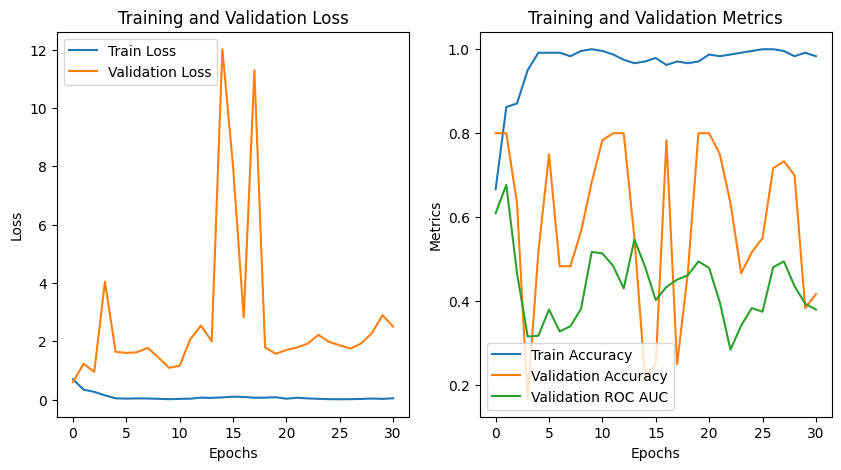

Accuracy: 0.8066666666666666
ROC AUC: 0.5899116557423767


In [32]:
# load data
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

# weight per class
class_counts = np.bincount(y_train_binary_2.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_binary_2.astype(int)]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader_binary = DataLoader(train_data_binary, batch_size=32, sampler=sampler)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

# ResNet50_1D
resnet_model = resnet50_1d()

# training process
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

num_epochs = 50
patience = 10
early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    resnet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = resnet_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    early_stopping(val_accuracy, resnet_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

# save best model
resnet_model.load_state_dict(torch.load('checkpoint.pt'))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
resnet_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = resnet_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


# RNN Model

- (300, 1000) -> (300, 1000, 1)

### Bidirectional LSTM Model

In [ ]:
# Bidirectional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

### phenotype 1

Epoch 1/10, Train Loss: 0.6960, Val Loss: 0.6910, Train Acc: 0.3333, Val Acc: 0.7333
Saving model with Validation Accuracy: 0.7333
Epoch 2/10, Train Loss: 0.6867, Val Loss: 0.6836, Train Acc: 0.8125, Val Acc: 0.7500
Saving model with Validation Accuracy: 0.7500
Epoch 3/10, Train Loss: 0.6769, Val Loss: 0.6761, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 4/10, Train Loss: 0.6676, Val Loss: 0.6683, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 5/10, Train Loss: 0.6574, Val Loss: 0.6603, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 6/10, Train Loss: 0.6466, Val Loss: 0.6513, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 7/10, Train Loss: 0.6339, Val Loss: 0.6409, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 8/10, Train Loss: 0.6186, Val Loss: 0.6286, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 9/10, Train Loss: 0.6005, Val Loss: 0.6140, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 10/10, Train Loss: 0.5789, Val Loss: 0.5963, Train Acc: 0.8125, Val Acc: 0.7500


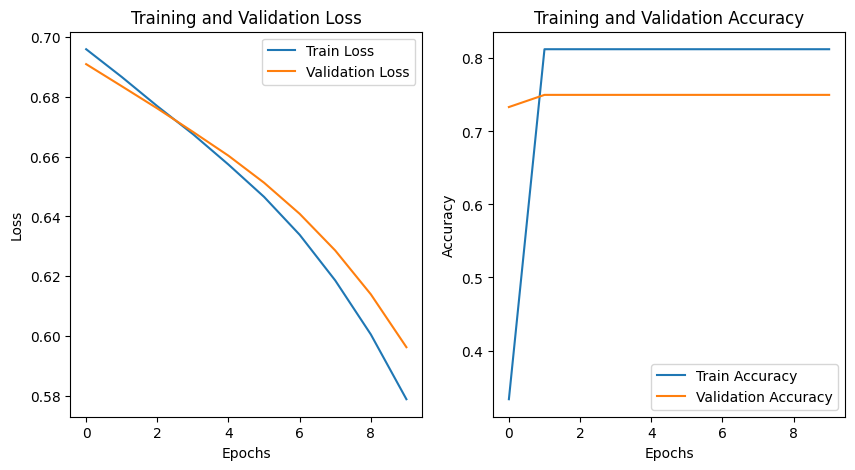

Accuracy: 0.8066666666666666
ROC AUC: 0.5739526930749502


In [5]:
# load data
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

# change the shape of the datset suitable for RNN training
# Time step = Number of SNP, Feature = 1 (one SNP)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

# set hyperparameter
input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train model
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 10
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

# load the best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# eval 
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/10, Train Loss: 0.6975, Val Loss: 0.6925, Train Acc: 0.2167, Val Acc: 0.7000
Saving model with Validation Accuracy: 0.7000
Epoch 2/10, Train Loss: 0.6898, Val Loss: 0.6839, Train Acc: 0.7583, Val Acc: 0.8333
Saving model with Validation Accuracy: 0.8333
Epoch 3/10, Train Loss: 0.6822, Val Loss: 0.6752, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 4/10, Train Loss: 0.6747, Val Loss: 0.6661, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 5/10, Train Loss: 0.6667, Val Loss: 0.6562, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 6/10, Train Loss: 0.6574, Val Loss: 0.6455, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 7/10, Train Loss: 0.6475, Val Loss: 0.6330, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 8/10, Train Loss: 0.6368, Val Loss: 0.6180, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 9/10, Train Loss: 0.6230, Val Loss: 0.6002, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 10/10, Train Loss: 0.6076, Val Loss: 0.5776, Train Acc: 0.7917, Val Acc: 0.8333


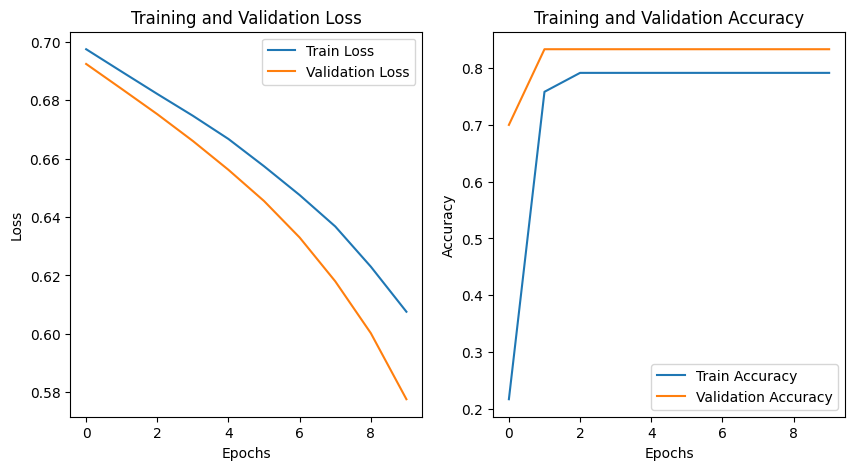

Accuracy: 0.8066666666666666
ROC AUC: 0.5528640638358506


In [33]:
# load data
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=7)

# transform data's shape suitable for RNN training
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

# set hyperparameter
input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train model
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 10
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


# BEST CASE : BiLSTM using RNN
- Various other approaches were tried using BiLSTM


## Increase Epoch : 10 -> 50

### phenotype 1

Epoch 1/50, Train Loss: 0.6906, Val Loss: 0.6870, Train Acc: 0.7125, Val Acc: 0.7500, Val ROC AUC: 0.5037
Saving model with Validation ROC AUC: 0.5037
Epoch 2/50, Train Loss: 0.6819, Val Loss: 0.6805, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5037
Epoch 3/50, Train Loss: 0.6737, Val Loss: 0.6736, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5022
Epoch 4/50, Train Loss: 0.6644, Val Loss: 0.6664, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.4993
Epoch 5/50, Train Loss: 0.6550, Val Loss: 0.6584, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5022
Epoch 6/50, Train Loss: 0.6445, Val Loss: 0.6494, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5007
Epoch 7/50, Train Loss: 0.6314, Val Loss: 0.6394, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5096
Saving model with Validation ROC AUC: 0.5096
Epoch 8/50, Train Loss: 0.6168, Val Loss: 0.6272, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5170
Saving model with Validation ROC AUC: 0.5170
Epoch 9/50, Train

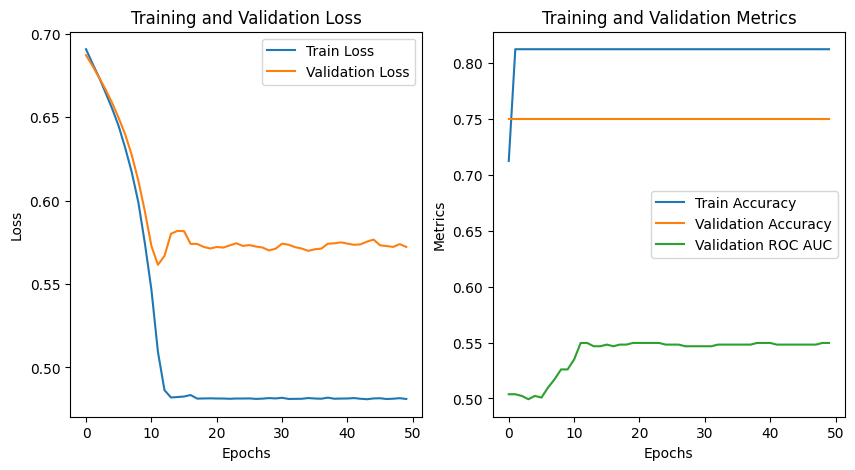

Accuracy: 0.8066666666666666
ROC AUC: 0.6571672841265317


In [11]:
# load dataset
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

# transform the dataset suitable for RNN training
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

# set hyper parameter
input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train model
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

# increased epochs (10 -> 50)
num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load the best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.6964, Val Loss: 0.6908, Train Acc: 0.2583, Val Acc: 0.8333, Val ROC AUC: 0.7220
Saving model with Validation ROC AUC: 0.7220
Epoch 2/50, Train Loss: 0.6877, Val Loss: 0.6808, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7080
Epoch 3/50, Train Loss: 0.6788, Val Loss: 0.6711, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7080
Epoch 4/50, Train Loss: 0.6707, Val Loss: 0.6606, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7100
Epoch 5/50, Train Loss: 0.6611, Val Loss: 0.6496, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7060
Epoch 6/50, Train Loss: 0.6516, Val Loss: 0.6370, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7040
Epoch 7/50, Train Loss: 0.6404, Val Loss: 0.6227, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7060
Epoch 8/50, Train Loss: 0.6273, Val Loss: 0.6062, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7020
Epoch 9/50, Train Loss: 0.6127, Val Loss: 0.5854, Train Acc: 0.7917, Val Acc: 0.8333, Val ROC AUC: 0.7020
E

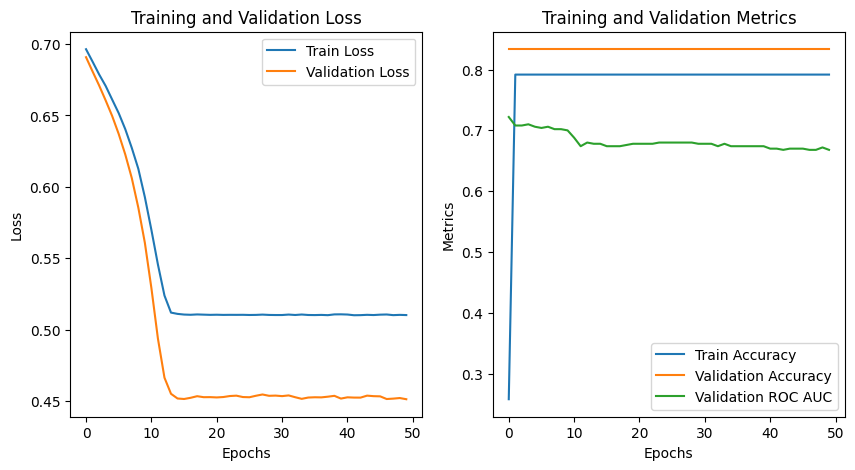

Accuracy: 0.8066666666666666
ROC AUC: 0.5847819891707039


In [34]:
# load dataset
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=7)

# transform data into suitable shape for RNN training
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

# set hyperparameter
input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train model
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

# increased number of epochs(10 -> 50)
num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load the best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


## Additional Batch Norm./Dropout layer

### Modified BiLSTM model

In [ ]:
# Bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5) # additional layer
        self.bn = nn.BatchNorm1d(hidden_dim * 2) # additional layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :] 
        out = self.dropout(out) # additional layer
        out = self.bn(out) # additional layer
        out = self.fc(out)
        return self.sigmoid(out)

### phenotype 1

Epoch 1/50, Train Loss: 0.7502, Val Loss: 0.6990, Train Acc: 0.4542, Val Acc: 0.2500, Val ROC AUC: 0.4844
Saving model with Validation ROC AUC: 0.4844
Epoch 2/50, Train Loss: 0.7379, Val Loss: 0.6979, Train Acc: 0.5042, Val Acc: 0.2500, Val ROC AUC: 0.4756
Epoch 3/50, Train Loss: 0.7345, Val Loss: 0.6945, Train Acc: 0.5333, Val Acc: 0.2500, Val ROC AUC: 0.4874
Saving model with Validation ROC AUC: 0.4874
Epoch 4/50, Train Loss: 0.7560, Val Loss: 0.6932, Train Acc: 0.4750, Val Acc: 0.6000, Val ROC AUC: 0.4919
Saving model with Validation ROC AUC: 0.4919
Epoch 5/50, Train Loss: 0.7106, Val Loss: 0.6926, Train Acc: 0.5250, Val Acc: 0.6000, Val ROC AUC: 0.4874
Epoch 6/50, Train Loss: 0.7260, Val Loss: 0.6896, Train Acc: 0.5417, Val Acc: 0.7000, Val ROC AUC: 0.4859
Epoch 7/50, Train Loss: 0.7276, Val Loss: 0.6933, Train Acc: 0.4625, Val Acc: 0.6000, Val ROC AUC: 0.4904
Epoch 8/50, Train Loss: 0.7156, Val Loss: 0.6869, Train Acc: 0.5042, Val Acc: 0.6000, Val ROC AUC: 0.4889
Epoch 9/50, Train

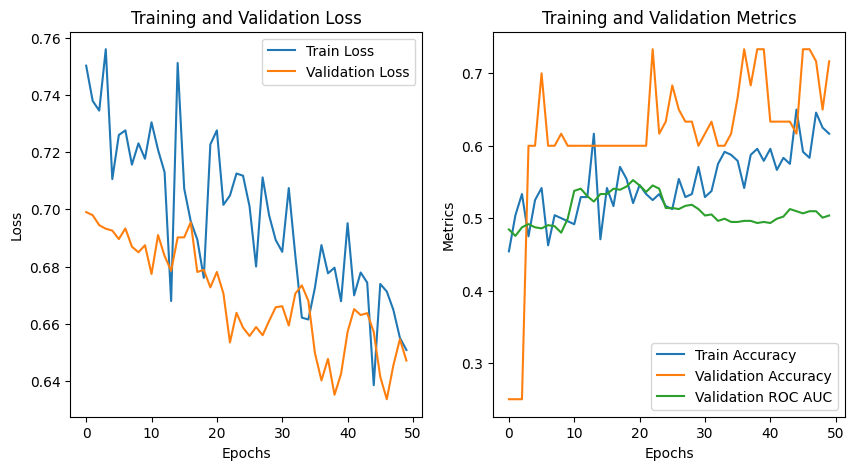

Accuracy: 0.64
ROC AUC: 0.6209746366486179


In [13]:
# data load
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

# transforming into RNN suitable shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load the best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.7482, Val Loss: 0.7187, Train Acc: 0.4625, Val Acc: 0.1667, Val ROC AUC: 0.3240
Saving model with Validation ROC AUC: 0.3240
Epoch 2/50, Train Loss: 0.7956, Val Loss: 0.7147, Train Acc: 0.4125, Val Acc: 0.1667, Val ROC AUC: 0.3320
Saving model with Validation ROC AUC: 0.3320
Epoch 3/50, Train Loss: 0.7295, Val Loss: 0.7116, Train Acc: 0.5083, Val Acc: 0.1667, Val ROC AUC: 0.3400
Saving model with Validation ROC AUC: 0.3400
Epoch 4/50, Train Loss: 0.8008, Val Loss: 0.7083, Train Acc: 0.4375, Val Acc: 0.1833, Val ROC AUC: 0.3580
Saving model with Validation ROC AUC: 0.3580
Epoch 5/50, Train Loss: 0.7526, Val Loss: 0.7108, Train Acc: 0.4542, Val Acc: 0.1833, Val ROC AUC: 0.5100
Saving model with Validation ROC AUC: 0.5100
Epoch 6/50, Train Loss: 0.7588, Val Loss: 0.7147, Train Acc: 0.4667, Val Acc: 0.1833, Val ROC AUC: 0.5320
Saving model with Validation ROC AUC: 0.5320
Epoch 7/50, Train Loss: 0.7300, Val Loss: 0.7104, Train Acc: 0.4917, Val Acc: 0.1833, Val ROC 

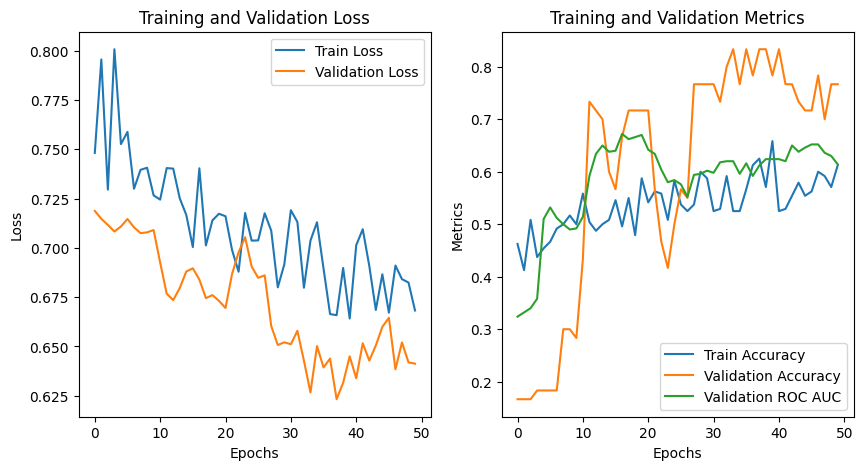

Accuracy: 0.6066666666666667
ROC AUC: 0.5682530635508692


In [35]:
# data load
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=7)

# transform into suitable shape for training RNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


## Learning rate adjustment / Gradient clipping

### BiLSTM model

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 마지막 시점의 은닉 상태
        out = self.fc(out)
        return self.sigmoid(out)

### phenotype 1

Epoch 1/50, Train Loss: 0.7110, Val Loss: 0.7028, Train Acc: 0.1875, Val Acc: 0.2500
Saving model with Validation Accuracy: 0.2500
Epoch 2/50, Train Loss: 0.7011, Val Loss: 0.6949, Train Acc: 0.1875, Val Acc: 0.2500
Epoch 3/50, Train Loss: 0.6911, Val Loss: 0.6868, Train Acc: 0.6417, Val Acc: 0.7500
Saving model with Validation Accuracy: 0.7500
Epoch 4/50, Train Loss: 0.6806, Val Loss: 0.6781, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 5/50, Train Loss: 0.6694, Val Loss: 0.6687, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 6/50, Train Loss: 0.6565, Val Loss: 0.6581, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 7/50, Train Loss: 0.6417, Val Loss: 0.6458, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 8/50, Train Loss: 0.6247, Val Loss: 0.6310, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 9/50, Train Loss: 0.6044, Val Loss: 0.6141, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 10/50, Train Loss: 0.5789, Val Loss: 0.5955, Train Acc: 0.8125, Val Acc: 0.7500
Epoch 11/50, Train Loss: 0.5505, Val Loss: 0.5762, Train 

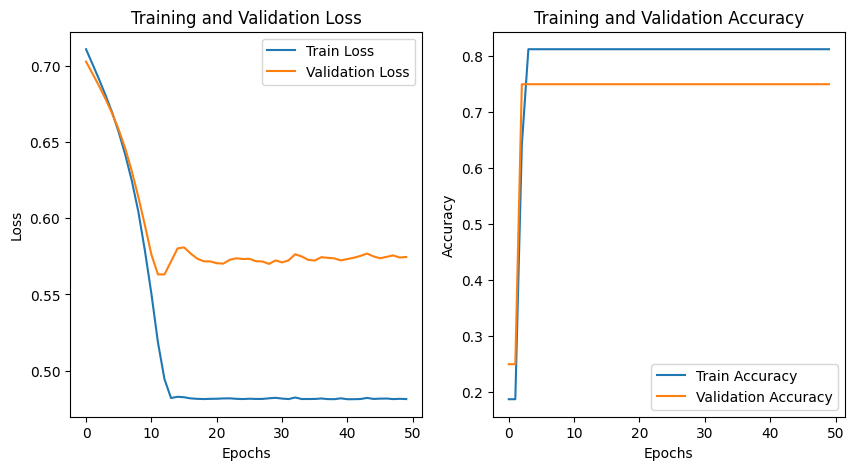

Accuracy: 0.8066666666666666
ROC AUC: 0.5599886007409518


In [37]:
# load dataset
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.6923, Val Loss: 0.6865, Train Acc: 0.5542, Val Acc: 0.8333
Saving model with Validation Accuracy: 0.8333
Epoch 2/50, Train Loss: 0.6840, Val Loss: 0.6771, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 3/50, Train Loss: 0.6760, Val Loss: 0.6672, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 4/50, Train Loss: 0.6673, Val Loss: 0.6569, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 5/50, Train Loss: 0.6579, Val Loss: 0.6453, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 6/50, Train Loss: 0.6475, Val Loss: 0.6322, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 7/50, Train Loss: 0.6359, Val Loss: 0.6166, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 8/50, Train Loss: 0.6210, Val Loss: 0.5983, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 9/50, Train Loss: 0.6051, Val Loss: 0.5744, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 10/50, Train Loss: 0.5829, Val Loss: 0.5465, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 11/50, Train Loss: 0.5588, Val Loss: 0.5132, Train Acc: 0.7917, Val Acc: 0.8333
Epoch 12/50, Trai

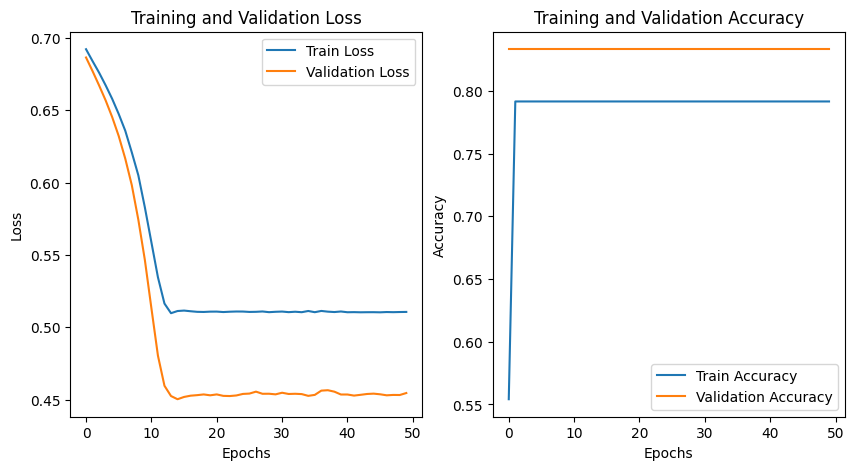

Accuracy: 0.8066666666666666
ROC AUC: 0.5619834710743802


In [39]:
# load dataset
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=7)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


## Use 'ROC AUC' as a training metric

### BiLSTM model

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

### phenotype 1

Epoch 1/50, Train Loss: 0.6787, Val Loss: 0.6780, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5111
Saving model with Validation ROC AUC: 0.5111
Epoch 2/50, Train Loss: 0.6705, Val Loss: 0.6714, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5052
Epoch 3/50, Train Loss: 0.6619, Val Loss: 0.6646, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5037
Epoch 4/50, Train Loss: 0.6534, Val Loss: 0.6573, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5022
Epoch 5/50, Train Loss: 0.6432, Val Loss: 0.6495, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5067
Epoch 6/50, Train Loss: 0.6325, Val Loss: 0.6406, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5126
Saving model with Validation ROC AUC: 0.5126
Epoch 7/50, Train Loss: 0.6201, Val Loss: 0.6304, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5170
Saving model with Validation ROC AUC: 0.5170
Epoch 8/50, Train Loss: 0.6056, Val Loss: 0.6182, Train Acc: 0.8125, Val Acc: 0.7500, Val ROC AUC: 0.5230
Saving model with

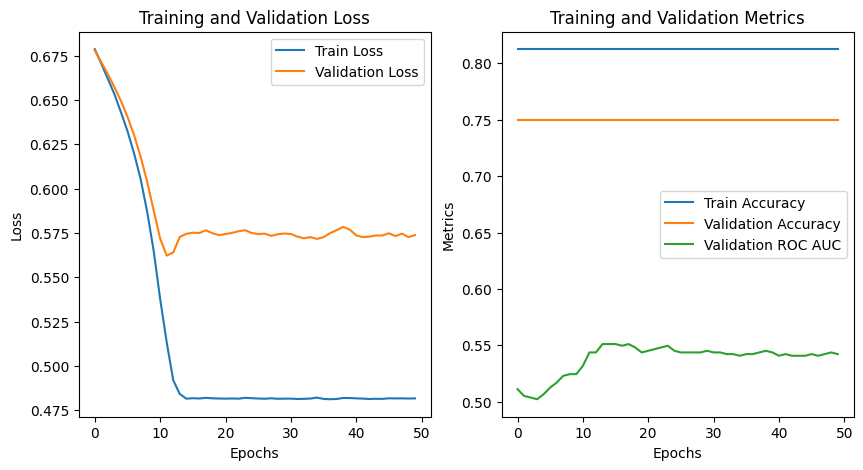

Accuracy: 0.8066666666666666
ROC AUC: 0.6543174693644913


In [12]:
# data load
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    # save the model with best ROC AUC score
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# training process visualization 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.6870, Val Loss: 0.6819, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6372
Saving model with Validation ROC AUC: 0.6372
Epoch 2/50, Train Loss: 0.6787, Val Loss: 0.6732, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6372
Epoch 3/50, Train Loss: 0.6703, Val Loss: 0.6641, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6337
Epoch 4/50, Train Loss: 0.6609, Val Loss: 0.6545, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6354
Epoch 5/50, Train Loss: 0.6509, Val Loss: 0.6438, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6354
Epoch 6/50, Train Loss: 0.6397, Val Loss: 0.6312, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6372
Epoch 7/50, Train Loss: 0.6264, Val Loss: 0.6167, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6337
Epoch 8/50, Train Loss: 0.6107, Val Loss: 0.5986, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6337
Epoch 9/50, Train Loss: 0.5907, Val Loss: 0.5768, Train Acc: 0.8000, Val Acc: 0.8000, Val ROC AUC: 0.6354
E

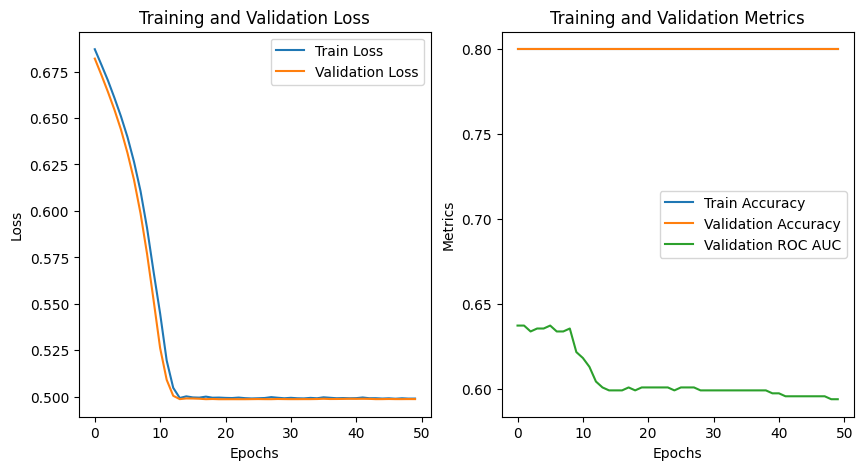

Accuracy: 0.8066666666666666
ROC AUC: 0.5797948133371331


In [40]:
# data load
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    # save the model with best ROC AUC score
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

# load best fit model
bilstm_model.load_state_dict(torch.load(best_model_path))

# visualize training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


## SMOTE method
- Used to address class imbalance
- Generating systhetic samples for the minority class

### BiLSTM model

In [ ]:
# Bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.bn(out)
        out = self.fc(out)
        return self.sigmoid(out)

### phenotype 1

Epoch 1/50, Train Loss: 0.7074, Val Loss: 0.6953, Train Acc: 0.5359, Val Acc: 0.2500, Val ROC AUC: 0.4978
Saving model with Validation Accuracy: 0.2500
Epoch 2/50, Train Loss: 0.7020, Val Loss: 0.6957, Train Acc: 0.5462, Val Acc: 0.2500, Val ROC AUC: 0.4756
Epoch 3/50, Train Loss: 0.7296, Val Loss: 0.6995, Train Acc: 0.4923, Val Acc: 0.2500, Val ROC AUC: 0.4681
Epoch 4/50, Train Loss: 0.7199, Val Loss: 0.6963, Train Acc: 0.5128, Val Acc: 0.3000, Val ROC AUC: 0.4533
Saving model with Validation Accuracy: 0.3000
Epoch 5/50, Train Loss: 0.7210, Val Loss: 0.6964, Train Acc: 0.5103, Val Acc: 0.4833, Val ROC AUC: 0.4356
Saving model with Validation Accuracy: 0.4833
Epoch 6/50, Train Loss: 0.7067, Val Loss: 0.6905, Train Acc: 0.5308, Val Acc: 0.6000, Val ROC AUC: 0.4548
Saving model with Validation Accuracy: 0.6000
Epoch 7/50, Train Loss: 0.7126, Val Loss: 0.6926, Train Acc: 0.5154, Val Acc: 0.6000, Val ROC AUC: 0.4637
Epoch 8/50, Train Loss: 0.7186, Val Loss: 0.6910, Train Acc: 0.5308, Val A

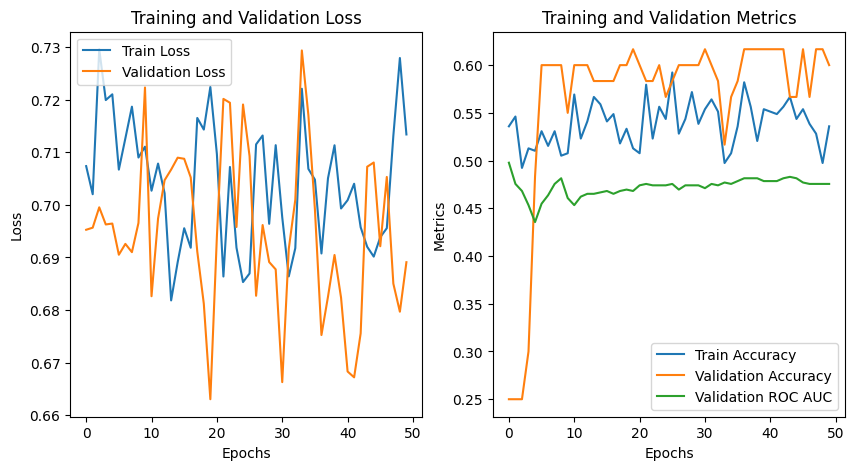

Accuracy: 0.6333333333333333
ROC AUC: 0.4967227130236534


In [16]:
X = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
y = train_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling using the technique 'SMOTE'
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_resampled_reshaped, dtype=torch.float32), torch.tensor(y_resampled, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_resampled_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

bilstm_model.load_state_dict(torch.load(best_model_path))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.7161, Val Loss: 0.6725, Train Acc: 0.5395, Val Acc: 0.8333, Val ROC AUC: 0.5740
Saving model with Validation Accuracy: 0.8333
Epoch 2/50, Train Loss: 0.7167, Val Loss: 0.6740, Train Acc: 0.5368, Val Acc: 0.8333, Val ROC AUC: 0.5840
Epoch 3/50, Train Loss: 0.7409, Val Loss: 0.6730, Train Acc: 0.4895, Val Acc: 0.8333, Val ROC AUC: 0.5760
Epoch 4/50, Train Loss: 0.7292, Val Loss: 0.6697, Train Acc: 0.5079, Val Acc: 0.8333, Val ROC AUC: 0.5680
Epoch 5/50, Train Loss: 0.7369, Val Loss: 0.6699, Train Acc: 0.5158, Val Acc: 0.8167, Val ROC AUC: 0.5460
Epoch 6/50, Train Loss: 0.7109, Val Loss: 0.6681, Train Acc: 0.5132, Val Acc: 0.7167, Val ROC AUC: 0.5320
Epoch 7/50, Train Loss: 0.7270, Val Loss: 0.6706, Train Acc: 0.4921, Val Acc: 0.7000, Val ROC AUC: 0.5300
Epoch 8/50, Train Loss: 0.7300, Val Loss: 0.6652, Train Acc: 0.5158, Val Acc: 0.7000, Val ROC AUC: 0.5280
Epoch 9/50, Train Loss: 0.7184, Val Loss: 0.6775, Train Acc: 0.5500, Val Acc: 0.7000, Val ROC AUC: 0.5200


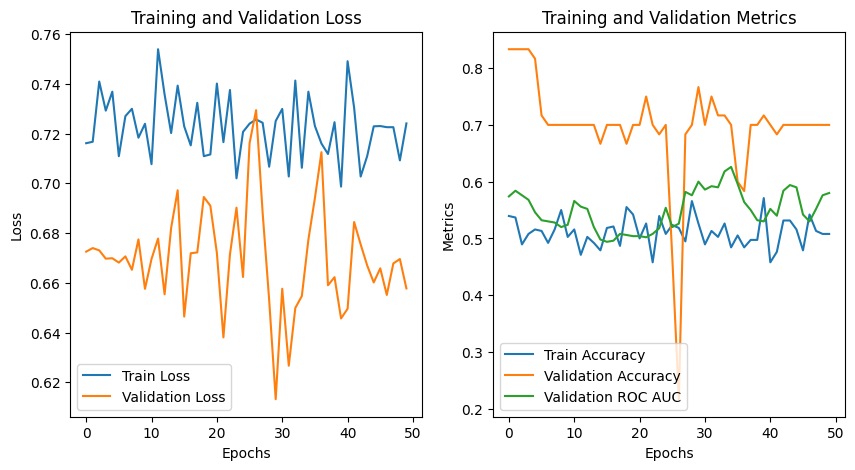

Accuracy: 0.8066666666666666
ROC AUC: 0.45041322314049587


In [9]:
X = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
y = train_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Oversampling using technique SMOTE
smote = SMOTE(random_state=7)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_resampled_reshaped, dtype=torch.float32), torch.tensor(y_resampled, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

train_loader_binary = DataLoader(train_data_binary, batch_size=32, shuffle=True)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_resampled_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_accuracy = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation Accuracy: {best_val_accuracy:.4f}')

bilstm_model.load_state_dict(torch.load(best_model_path))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


## Differentiate weights for each class

### phenotype 1

Epoch 1/50, Train Loss: 0.7193, Val Loss: 0.6947, Train Acc: 0.5167, Val Acc: 0.2500, Val ROC AUC: 0.5044
Saving model with Validation ROC AUC: 0.5044
Epoch 2/50, Train Loss: 0.7265, Val Loss: 0.6950, Train Acc: 0.5167, Val Acc: 0.2500, Val ROC AUC: 0.4970
Epoch 3/50, Train Loss: 0.7404, Val Loss: 0.6948, Train Acc: 0.4917, Val Acc: 0.2667, Val ROC AUC: 0.4978
Epoch 4/50, Train Loss: 0.7121, Val Loss: 0.6951, Train Acc: 0.4875, Val Acc: 0.3833, Val ROC AUC: 0.4978
Epoch 5/50, Train Loss: 0.7489, Val Loss: 0.6951, Train Acc: 0.4833, Val Acc: 0.4833, Val ROC AUC: 0.4963
Epoch 6/50, Train Loss: 0.7280, Val Loss: 0.6920, Train Acc: 0.4958, Val Acc: 0.5667, Val ROC AUC: 0.4963
Epoch 7/50, Train Loss: 0.7440, Val Loss: 0.6899, Train Acc: 0.4750, Val Acc: 0.6000, Val ROC AUC: 0.4978
Epoch 8/50, Train Loss: 0.6983, Val Loss: 0.6888, Train Acc: 0.5667, Val Acc: 0.6000, Val ROC AUC: 0.5007
Epoch 9/50, Train Loss: 0.7495, Val Loss: 0.6846, Train Acc: 0.5042, Val Acc: 0.6000, Val ROC AUC: 0.5007
E

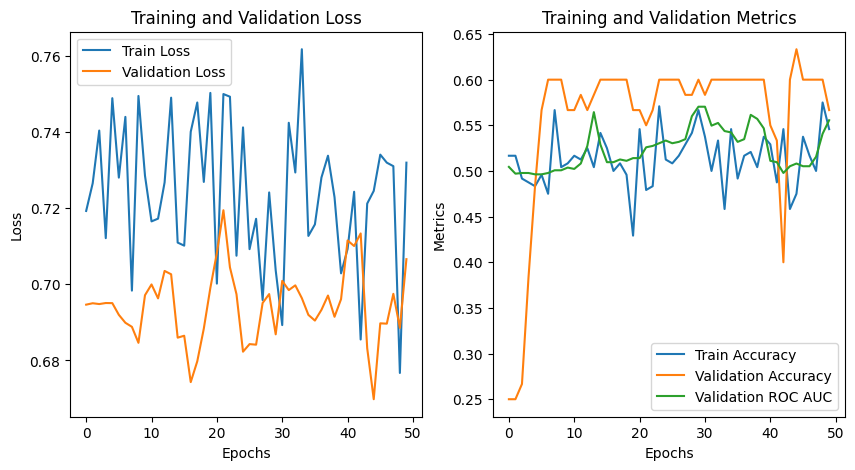

Accuracy: 0.6266666666666667
ROC AUC: 0.5785123966942148


In [17]:
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_1 = train_pheno_binary['pheno_1_bin'].values
y_test_binary_1 = test_pheno_binary['pheno_1_bin'].values

X_train, X_val, y_train_binary_1, y_val_binary_1 = train_test_split(X_train, y_train_binary_1, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_1, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_1, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_1, dtype=torch.float32))

# differentiate weights for each class ( more weight to the out-numbered one )
class_counts = np.bincount(y_train_binary_1.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_binary_1.astype(int)]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader_binary = DataLoader(train_data_binary, batch_size=32, sampler=sampler)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# train
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

bilstm_model.load_state_dict(torch.load(best_model_path))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

# eval
bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


### phenotype 2

Epoch 1/50, Train Loss: 0.7530, Val Loss: 0.6747, Train Acc: 0.4875, Val Acc: 0.8333, Val ROC AUC: 0.7160
Saving model with Validation ROC AUC: 0.7160
Epoch 2/50, Train Loss: 0.7438, Val Loss: 0.6771, Train Acc: 0.4875, Val Acc: 0.8333, Val ROC AUC: 0.7140
Epoch 3/50, Train Loss: 0.7218, Val Loss: 0.6761, Train Acc: 0.5125, Val Acc: 0.8333, Val ROC AUC: 0.7140
Epoch 4/50, Train Loss: 0.7112, Val Loss: 0.6774, Train Acc: 0.5083, Val Acc: 0.8333, Val ROC AUC: 0.7120
Epoch 5/50, Train Loss: 0.7099, Val Loss: 0.6812, Train Acc: 0.5125, Val Acc: 0.8333, Val ROC AUC: 0.7100
Epoch 6/50, Train Loss: 0.7029, Val Loss: 0.6828, Train Acc: 0.5167, Val Acc: 0.8167, Val ROC AUC: 0.7100
Epoch 7/50, Train Loss: 0.7440, Val Loss: 0.6816, Train Acc: 0.4917, Val Acc: 0.8000, Val ROC AUC: 0.7140
Epoch 8/50, Train Loss: 0.7201, Val Loss: 0.6912, Train Acc: 0.4833, Val Acc: 0.6500, Val ROC AUC: 0.7140
Epoch 9/50, Train Loss: 0.7203, Val Loss: 0.6853, Train Acc: 0.5042, Val Acc: 0.7000, Val ROC AUC: 0.7180
S

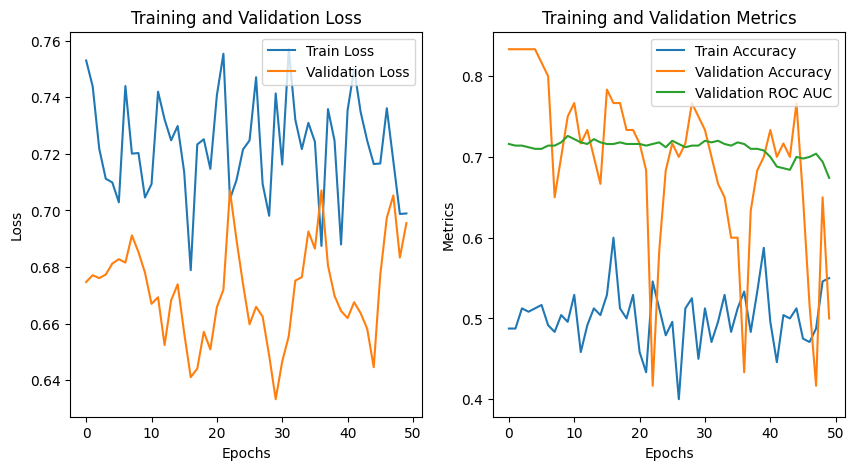

Accuracy: 0.6666666666666666
ROC AUC: 0.58592191507552


In [11]:
X_train = train_geno_dose.drop(columns=['family_id', 'individual_id']).values
X_test = test_geno_dose.drop(columns=['family_id', 'individual_id']).values

y_train_binary_2 = train_pheno_binary['pheno_2_bin'].values
y_test_binary_2 = test_pheno_binary['pheno_2_bin'].values

X_train, X_val, y_train_binary_2, y_val_binary_2 = train_test_split(X_train, y_train_binary_2, test_size=0.2, random_state=7)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_data_binary = TensorDataset(torch.tensor(X_train_reshaped, dtype=torch.float32), torch.tensor(y_train_binary_2, dtype=torch.float32))
val_data_binary = TensorDataset(torch.tensor(X_val_reshaped, dtype=torch.float32), torch.tensor(y_val_binary_2, dtype=torch.float32))
test_data_binary = TensorDataset(torch.tensor(X_test_reshaped, dtype=torch.float32), torch.tensor(y_test_binary_2, dtype=torch.float32))

# class weights differentiation
class_counts = np.bincount(y_train_binary_2.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_binary_2.astype(int)]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader_binary = DataLoader(train_data_binary, batch_size=32, sampler=sampler)
val_loader_binary = DataLoader(val_data_binary, batch_size=32, shuffle=False)
test_loader_binary = DataLoader(test_data_binary, batch_size=32, shuffle=False)

input_dim = X_train_reshaped.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 50
best_val_roc_auc = -np.Inf
best_model_path = 'best_bilstm_model.pt'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_roc_aucs = []

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader_binary:
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    train_loss = running_loss / len(train_loader_binary.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    bilstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
        for inputs, targets in val_loader_binary:
            outputs = bilstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            y_val_pred.extend(outputs.squeeze().numpy())
            y_val_true.extend(targets.numpy())
    val_loss = running_loss / len(val_loader_binary.dataset)
    val_accuracy = correct / total
    val_roc_auc = roc_auc_score(y_val_true, y_val_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
    
    if val_roc_auc > best_val_roc_auc:
        best_val_roc_auc = val_roc_auc
        torch.save(bilstm_model.state_dict(), best_model_path)
        print(f'Saving model with Validation ROC AUC: {best_val_roc_auc:.4f}')

bilstm_model.load_state_dict(torch.load(best_model_path))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(val_roc_aucs, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()

plt.show()

bilstm_model.eval()
y_pred_binary_1 = []
with torch.no_grad():
    for inputs, _ in test_loader_binary:
        outputs = bilstm_model(inputs)
        y_pred_binary_1.extend(outputs.squeeze().numpy())
y_pred_binary_1 = np.array(y_pred_binary_1)
accuracy = accuracy_score(y_test_binary_1, (y_pred_binary_1 > 0.5).astype(int))
roc_auc = roc_auc_score(y_test_binary_1, y_pred_binary_1)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
